In [1]:
from PyHessian.pyhessian.hessian import hessian
from PyHessian.density_plot import get_esd_plot
from hessian_utils import *
import torch
from sklearn.datasets import make_classification
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision.transforms as transforms
import torchvision
%matplotlib inline
torch.manual_seed(42)

In [2]:
# Hyperparameters
batch_size = 64
epochs = 10
learning_rate = 0.001

# Transformation to downscale images to 14x14 and normalize
transform = transforms.Compose([
    transforms.Resize((14, 14)),  # Downscale image to 14x14
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize image
])

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data/mnist', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data/mnist', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the simplified CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.linear = nn.Linear(8 * 3 * 3, 10)
    
    
    def forward(self, x):
        # Apply first convolutional layer + ReLU activation
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

In [ ]:
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Check the number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total number of parameters in the model: {count_parameters(model)}")

# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Track statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # Print statistics every 100 batches
        if i % 100 == 99:
            print(f"Epoch {epoch+1}/{epochs}, Iteration {i+1}/{len(train_loader)}, Loss: {running_loss / 100:.4f}")
            running_loss = 0.0
    
    # Print statistics for each epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

# Test the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

In [3]:
# Find test accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Test accuracy: {correct / total}')

Test accuracy: 0.9661


In [3]:
# Randomly sample 100 images from the train set for hessian estimation
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
x_samples = []
y_samples = []
for inputs, labels in train_loader:
    x_samples.append(inputs)
    y_samples.append(labels)
    break
x_samples = torch.cat(x_samples)
y_samples = torch.cat(y_samples)
loader = DataLoader(TensorDataset(x_samples, y_samples), batch_size=1)

In [5]:
hess = compute_hessian(model, criterion, x_samples, y_samples)
pred_hess = hessian(model, criterion, dataloader=loader, cuda=False)

print("Computed Hessian matrix")
vals, vecs = np.linalg.eigh(hess)
vecs = vecs.T
print("Computed eigenvalues and eigenvectors")

Computed Hessian matrix
Computed eigenvalues and eigenvectors


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/autograd/__init__.py:266: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1177.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


/teamspace/studios/this_studio/DeepHessian/PyHessian/density_plot.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
  density_output[i, j] = np.sum(tmp_result * weights[i, :])


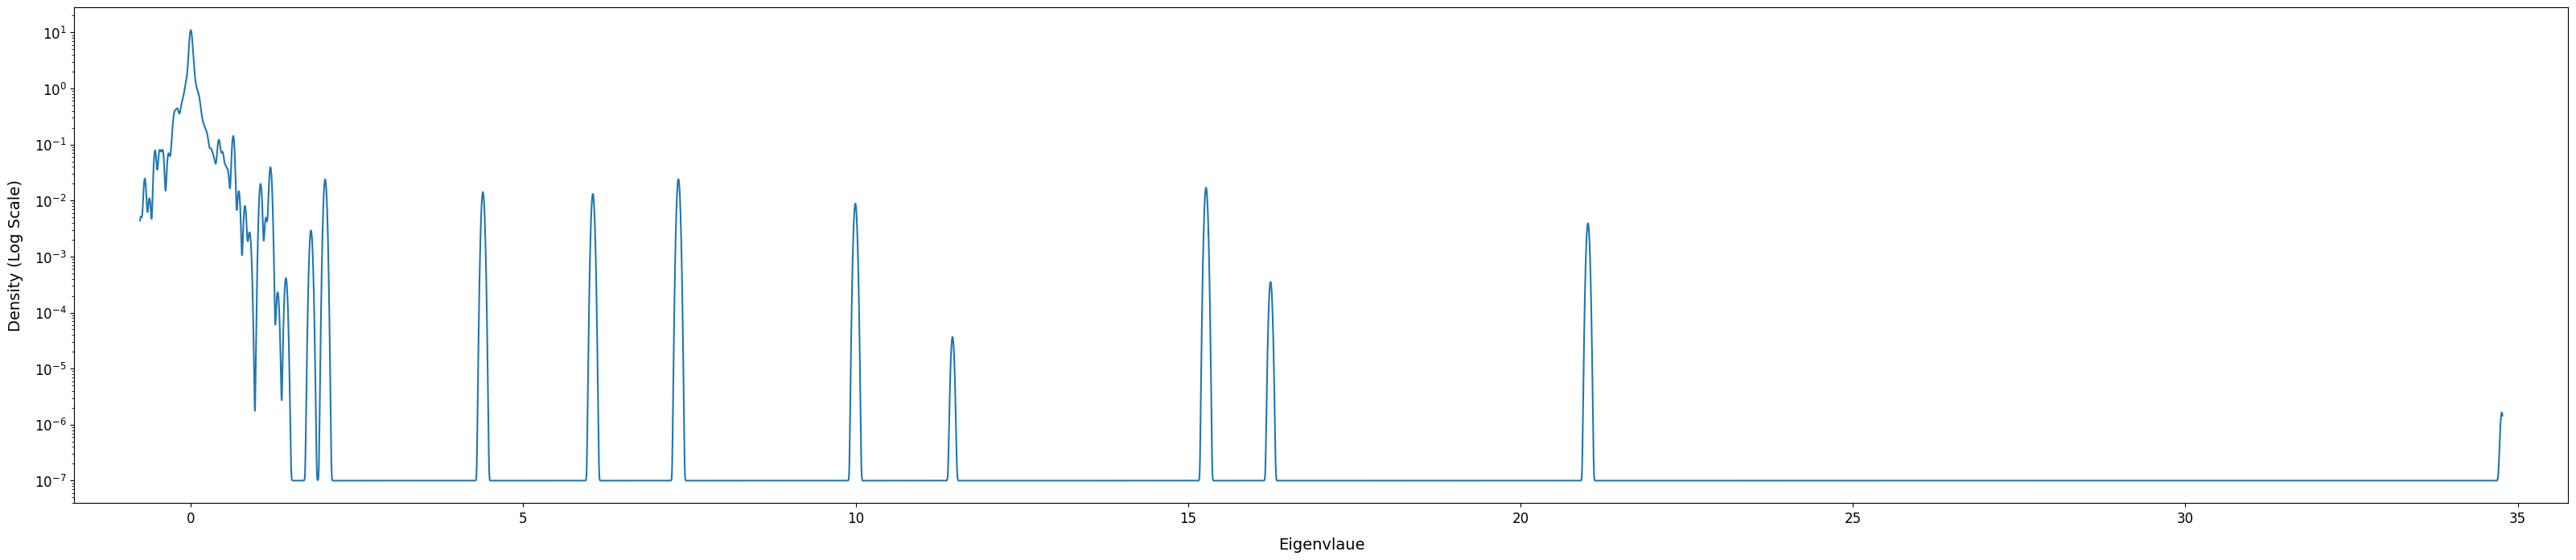

In [6]:
get_esd_plot(*pred_hess.density())

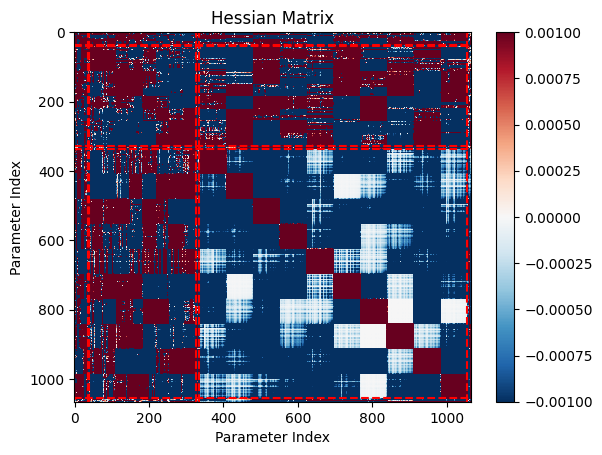

In [7]:
# Display the hessian 
plot_hessian(model, criterion, x_samples, y_samples)

In [8]:
true_couple = list(zip(vals, vecs))
# Sort the couple based on absolute value of the eigenvalues
true_couple.sort(key=lambda x: abs(x[0]))
true_couple.reverse()

In [4]:
def get_reconstruction_loss(matrix):
    vals, vecs = np.linalg.eigh(matrix)
    vecs = vecs.T
    couple = list(zip(vals, vecs))
    couple.sort(key=lambda x: abs(x[0]))
    couple.reverse()
    current_matrix = np.zeros(matrix.shape)
    errors = []
    for i in range(len(couple)):
        val, vec = couple[i]
        reconstructed_matrix = val * np.outer(vec, vec)
        current_matrix += reconstructed_matrix
        error = np.linalg.norm(current_matrix - matrix) / np.linalg.norm(matrix)
        errors.append(error)
    return errors

def plot_reconstruction_loss(errors, epsilon=None, acc = None, title="Reconstruction Loss", save_path = None):
    plt.plot(errors)
    plt.xlabel("Number of Eigenvalues")
    plt.ylabel("Relative Error")
    plt.title(title)
    if epsilon is not None:
        num_required = np.argmax(np.array(errors) < epsilon)
        plt.axvline(x=num_required, color='r', linestyle='--', label=f"Number of Eigenvalues: {num_required} for epsilon={epsilon}")
        # Horizontal line for epsilon
        plt.axhline(y=epsilon, color='g', linestyle='--', label=f"Epsilon: {epsilon}")
        plt.legend()
    # Add a box on the right showing the test accuracy of the model (given by acc)
    if acc is not None:
        plt.text(0.7, 0.7, f"Test Accuracy: {100*acc:.2f}%", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes,
                 bbox=dict(facecolor='white', alpha=0.5))

    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

def accuracy(model, test_data):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_data:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

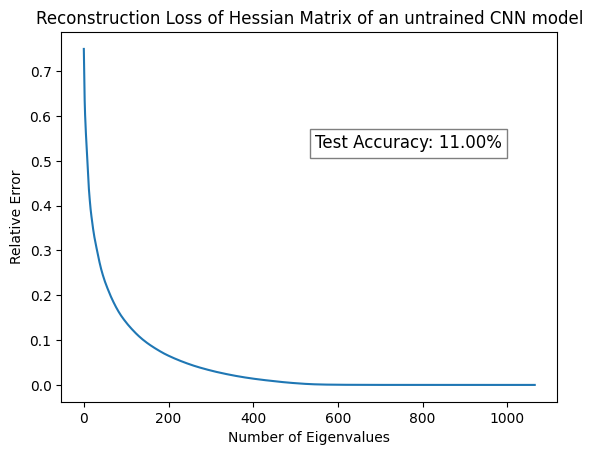

In [10]:
# Using a random matrix to test the function
# random_matrix = np.random.rand(692, 692)
# random_matrix = random_matrix @ random_matrix.T
model_init = SimpleCNN()
hess_init = np.array(compute_hessian(model_init, criterion, x_samples, y_samples))
errors = get_reconstruction_loss(hess_init)
plot_reconstruction_loss(errors, acc = accuracy(model_init, loader),  title="Reconstruction Loss of Hessian Matrix of an untrained CNN model")

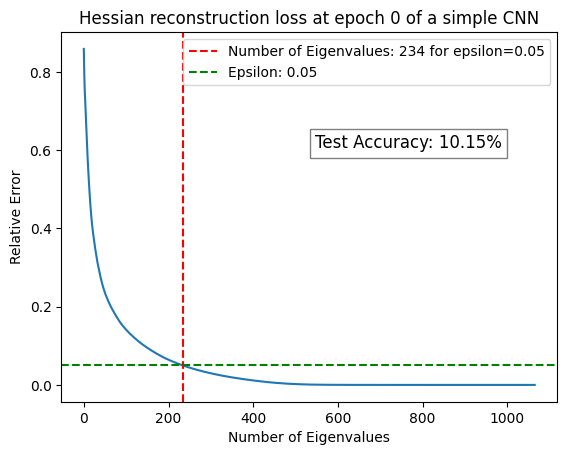

Epoch 1/10, Loss: 0.5196205377578735


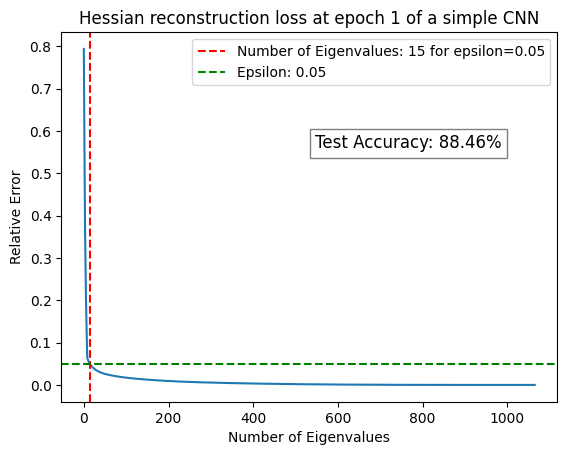

Epoch 2/10, Loss: 0.30275455117225647


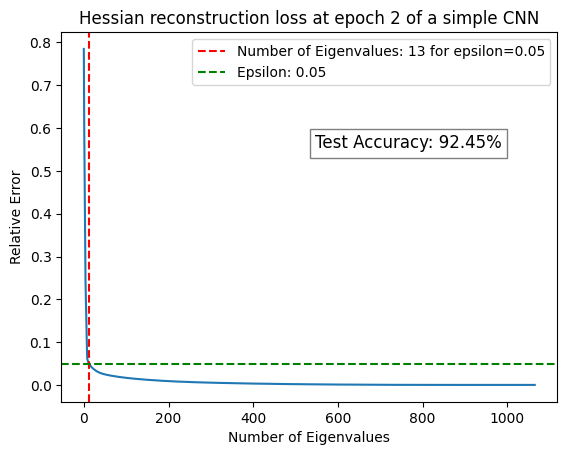

Epoch 3/10, Loss: 0.17416109144687653


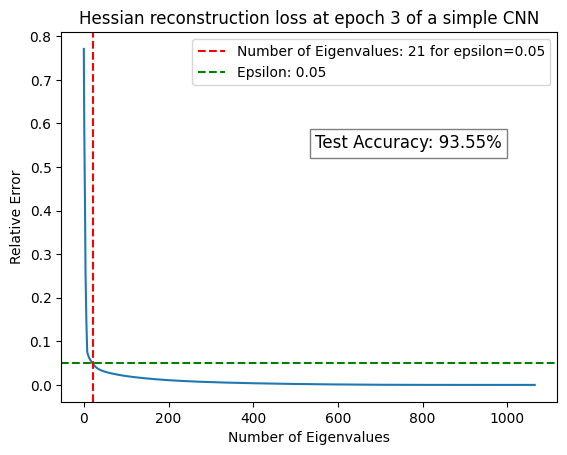

Epoch 4/10, Loss: 0.3054513931274414


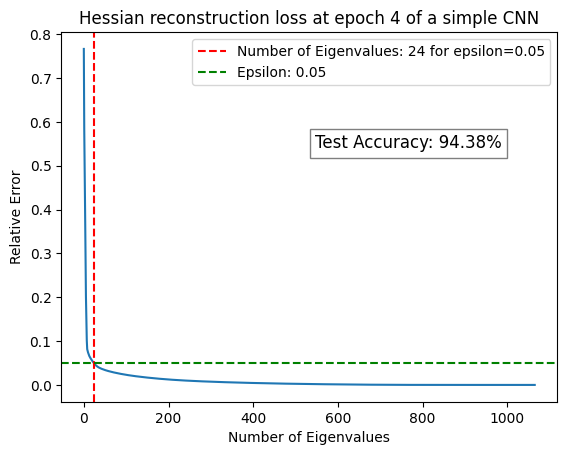

Epoch 5/10, Loss: 0.2803882360458374


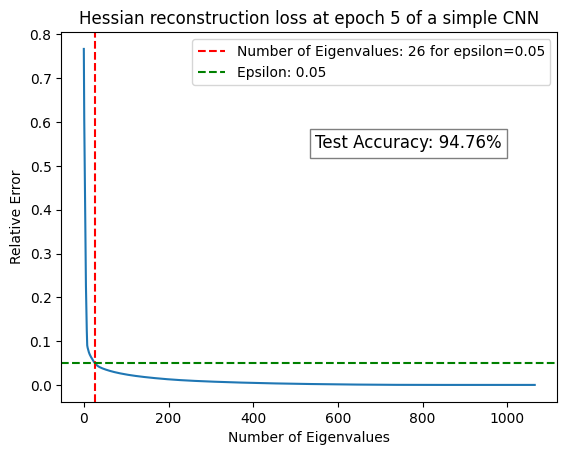

Epoch 6/10, Loss: 0.19729427993297577


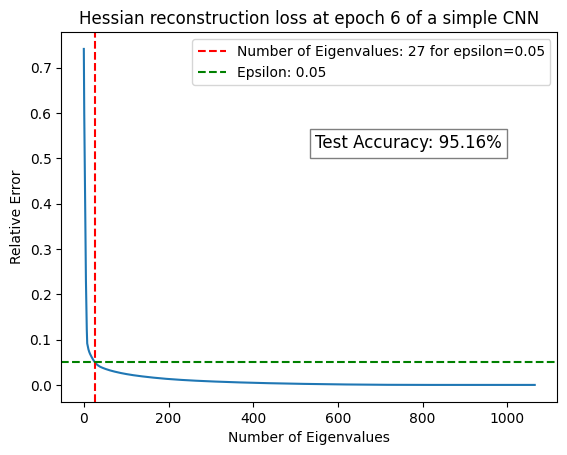

Epoch 7/10, Loss: 0.2476932853460312


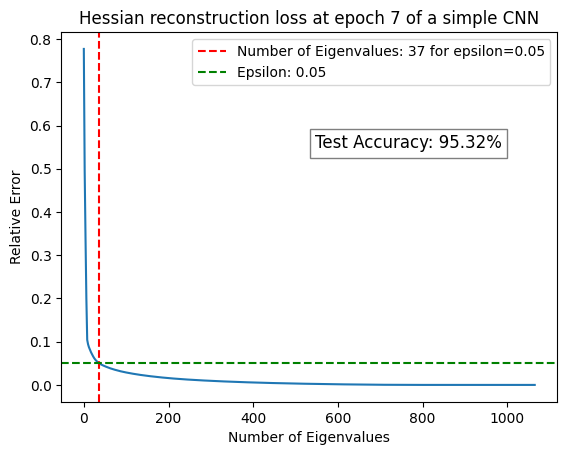

Epoch 8/10, Loss: 0.1251523643732071


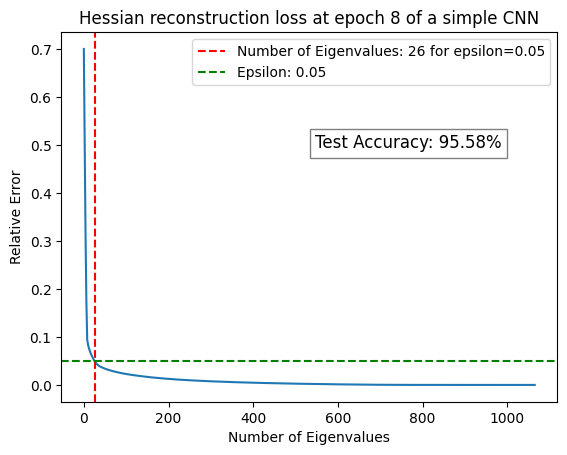

Epoch 9/10, Loss: 0.16353531181812286


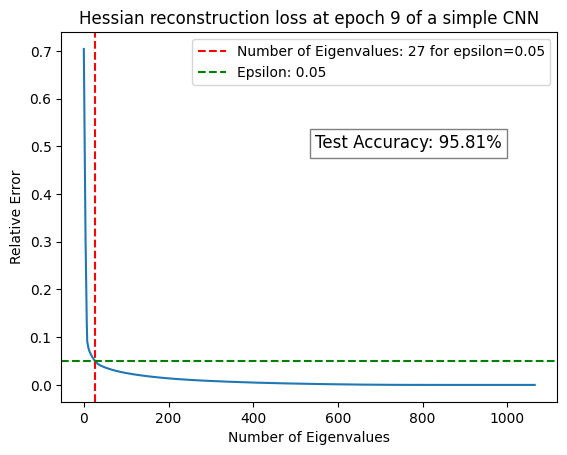

Epoch 10/10, Loss: 0.1299365609884262


In [11]:
# Finding hessian matrix per epoch and plotting the error in reconstruction
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epsilon = 0.05
num_req_arr = []
num_epochs = 10
for epoch in range(num_epochs):
    hessian_matrix = np.array(compute_hessian(model, criterion, x_samples, y_samples))
    errors = get_reconstruction_loss(hessian_matrix)
    num_required = np.argmax(np.array(errors) < epsilon)
    num_req_arr.append(num_required)
    acc = accuracy(model, test_loader)
    model.train()
    plot_reconstruction_loss(errors, epsilon=epsilon, acc = acc, title=f"Hessian reconstruction loss at epoch {epoch} of a simple CNN", save_path=f"hessian_reconstruction_cnn/epoch_{epoch}.png")
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

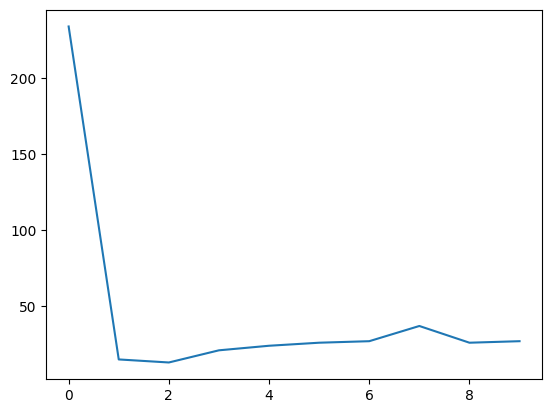

In [12]:
plt.plot(num_req_arr)

In [ ]:
# Get ESD plots throughout training:
losses = []
test_losses = []
train_losses = []
model = SimpleCNN()
for epoch in range(20):
    mh = Hessian_model(model, loader, criterion, n_classes=10)
    get_esd_plot(*mh.hessian_comp.density(), save_path=f'mnist_esd_images/mnist_esd_epoch_{epoch}.png', title=f'MNIST ESD Epoch {epoch}')
    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        #output_test = model(test_X)
        loss = criterion(output, target)
        # loss_test = criterion(output_test, test_y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        # if i % 500 == 0:
        #     output = model(val_x)
        #     loss_train = criterion(output, val_y)
        #     output = model(test_X)
        #     loss_test = criterion(output, test_y)
        #     print(f"Epoch {epoch}, step {i}, train_loss {loss.item()}, test_loss {loss_test.item()}")
        #     output_test = model(test_X)
        #     test_losses.append(loss_test.item())
        #     train_losses.append(loss_train.item())
    #print(loss.item())

In [6]:
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epsilon = 0.05
num_req_arr = []
num_epochs = 10
all_errors = []
for epoch in range(num_epochs):
    hessian_matrix = np.array(compute_hessian(model, criterion, x_samples, y_samples))
    errors = get_reconstruction_loss(hessian_matrix)
    all_errors.append(errors)
    #num_required = np.argmax(np.array(errors) < epsilon)
    #num_req_arr.append(num_required)
    #acc = accuracy(model, test_loader)
    #model.train()
    #plot_reconstruction_loss(errors, epsilon=epsilon, acc = acc, title=f"Hessian reconstruction loss at epoch {epoch} of a simple CNN", save_path=f"hessian_reconstruction_cnn/epoch_{epoch}.png")
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Epoch 1/10, Loss: 0.2342175543308258
Epoch 2/10, Loss: 0.19589494168758392
Epoch 3/10, Loss: 0.1381165087223053
Epoch 4/10, Loss: 0.1589442789554596
Epoch 5/10, Loss: 0.19994765520095825
Epoch 6/10, Loss: 0.10666929930448532
Epoch 7/10, Loss: 0.14539438486099243
Epoch 8/10, Loss: 0.05623473599553108
Epoch 9/10, Loss: 0.17040574550628662
Epoch 10/10, Loss: 0.05304761976003647


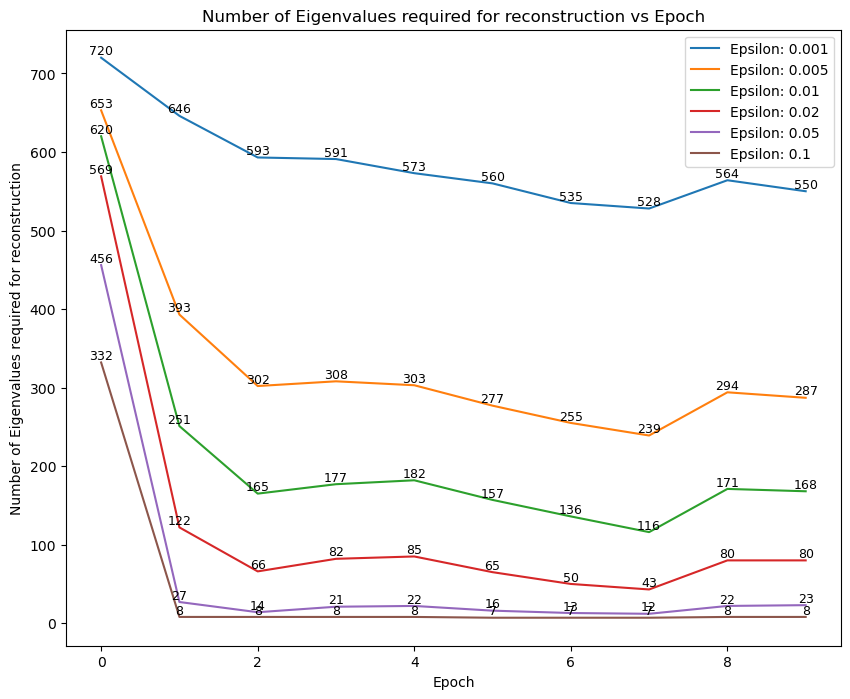

In [18]:
epsilons = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1]
# Also show the number of eigenvalues required for reconstruction
plt.figure(figsize=(10, 8))
for epsilon in epsilons:
    all_num_req = []
    for errors in all_errors:
        num_required = np.argmax(np.array(errors) < epsilon)
        all_num_req.append(num_required)
    # Add labels for ever datapoint

    plt.plot(all_num_req, label=f"Epsilon: {epsilon}")


    for i, num in enumerate(all_num_req):
        plt.text(i, num, str(num), fontsize=9, ha='center', va='bottom')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Number of Eigenvalues required for reconstruction")
plt.title("Number of Eigenvalues required for reconstruction vs Epoch")
#plt.tight_layout()
plt.show()

In [8]:
len(all_errors[0])

1066